In [24]:
from gluonts.dataset.split import split
from gluonts.torch import PatchTSTEstimator
from gluonts.dataset.pandas import PandasDataset
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import pandas as pd
from gluonts.dataset.common import ListDataset
import torch
from gluonts.model.predictor import Predictor
from sklearn.model_selection import train_test_split
import os
from lightning.pytorch import Trainer
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import ModelCheckpoint
import numpy as np

In [25]:
from pathlib import Path
import os

load_dotenv()

True

In [26]:
from data.get_data import get_data_frame, get_max_user_count

In [31]:
df = get_data_frame(1)
df.set_index('timestamp', inplace=True)

In [51]:
def prepare_data(df, freq="15min", prediction_length=96):
    """
    Prepare data with additional features
    """
    # Add time-based features
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['day_of_month'] = df.index.day
    df['month'] = df.index.month
    df['is_weekend'] = df.index.dayofweek.isin([5, 6]).astype(int)
    
    # Add rolling statistics
    df['rolling_mean_24h'] = df['user_count'].rolling(window=96).mean()  # 24h = 96 * 15min
    df['rolling_std_24h'] = df['user_count'].rolling(window=96).std()
    df['rolling_max_24h'] = df['user_count'].rolling(window=96).max()
    
    # Add lag features
    df['lag_1h'] = df['user_count'].shift(4)  # 1h = 4 * 15min
    df['lag_6h'] = df['user_count'].shift(24)
    df['lag_24h'] = df['user_count'].shift(96)
    
    # Fill NaN values
    df = df.fillna(method='bfill').fillna(method='ffill')
    
    # Create static features (if you have any domain-specific ones)
    # static_features = np.array([0])  # Add relevant static features
    train_length = int(len(df) * 0.8)
    
    # Prepare dynamic features
    dynamic_features_train = df.iloc[0:train_length][[
        'hour', 'day_of_week', 'day_of_month', 'month', 'is_weekend',
        'rolling_mean_24h', 'rolling_std_24h', 'rolling_max_24h',
        'lag_1h', 'lag_6h', 'lag_24h'
    ]].values

    dynamic_features_test = df.iloc[train_length:][[
        'hour', 'day_of_week', 'day_of_month', 'month', 'is_weekend',
        'rolling_mean_24h', 'rolling_std_24h', 'rolling_max_24h',
        'lag_1h', 'lag_6h', 'lag_24h'
    ]].values


    train_data = df.iloc[0:train_length]
    test_data = df.iloc[train_length:]

    # Create dataset with features
    dataset_train = ListDataset(
        [{
            "start": train_data.index[0],
            "target": train_data['user_count'].values,
            "dynamic_features": dynamic_features_train,
            # "static_features": static_features
        }],
        freq=freq
    )

    dataset_test = ListDataset(
        [{
            "start": test_data.index[0],
            "target": test_data['user_count'].values,
            "dynamic_features": dynamic_features_train,
            # "static_features": static_features
        }],
        freq=freq
    )
    
    return (dataset_train, dataset_test)


In [52]:
freq = "15min"
prediction_length = 96

dataset_train, dataset_test = prepare_data(df, freq, prediction_length) 

# Mock dataframe example (replace with your actual data)
# df = pd.DataFrame({"user_count": [...]}, index=pd.date_range(...))

# train_data, test_data = train_uutest_split(
#     df, 
#     test_size=0.2,  # 20% for testing
#     # shuffle=True, 
#     random_state=42  # For reproducibility
# )

# # Create training dataset
# train_ds = ListDataset(
#     [{"start": train_data.index[0], "target": train_data['user_count'].values}],
#     freq=freq
# )

# # Create testing dataset
# test_ds = ListDataset(
#     [{"start": test_data.index[0], "target": test_data['user_count'].values}],
#     freq=freq
# )

# Split into train/validation


# Set up CSV Logger
logger = CSVLogger(save_dir="./logs/", name="patchtst_training")

# Define checkpointing callback to save the model
model_checkpoint = ModelCheckpoint(
    dirpath="./models/",
    filename="best_model",
    save_top_k=1,
    monitor="val_loss",
    mode="min",
)

# Initialize estimator
estimatorTST = PatchTSTEstimator(
    prediction_length=prediction_length,
    context_length=prediction_length * 10,
    patch_len=16,
    stride=8,
    num_encoder_layers=3,  # Added parameter
    dropout=0.1,  # Added dropout for regularization
    scaling=True,  # Enable scaling of input data
    trainer_kwargs={
        "accelerator": "gpu",
        "max_epochs": 30,
        "logger": logger,
        "callbacks": [model_checkpoint],
        "log_every_n_steps": 1,
    }
)

/tmp/ipykernel_245228/4169569688.py:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill').fillna(method='ffill')


In [54]:
# Train the model using the train() method
predictorTST = estimatorTST.train(dataset_train)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PatchTSTModel | 11.8 M | train
------------------------------------------------
11.8 M    Trainable params
3.8 K     Non-trainable params
11.8 M    Total params
47.369    Total estimated model params size (MB)
44        Modules in train mode
0         Modules in eval mode


Training: |                                                                                     | 0/? [00:00<?…

Epoch 0, global step 50: 'train_loss' reached 8.36174 (best 8.36174), saving model to './logs/patchtst_training/version_10/checkpoints/epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.77325 (best 7.77325), saving model to './logs/patchtst_training/version_10/checkpoints/epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' was not in top 1
Epoch 3, global step 200: 'train_loss' reached 7.29690 (best 7.29690), saving model to './logs/patchtst_training/version_10/checkpoints/epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' reached 7.08711 (best 7.08711), saving model to './logs/patchtst_training/version_10/checkpoints/epoch=5-step=300.ckpt' as top 1
Epoch 6, global step 350: 'train_loss' reached 6.95410 (best 6.95410), saving model to './logs/patchtst_training/version_10/checkpoints/epoch=6-step=350.ckpt' as top 1
Epoch 7, global step 400: 'train_loss' reached 6.8

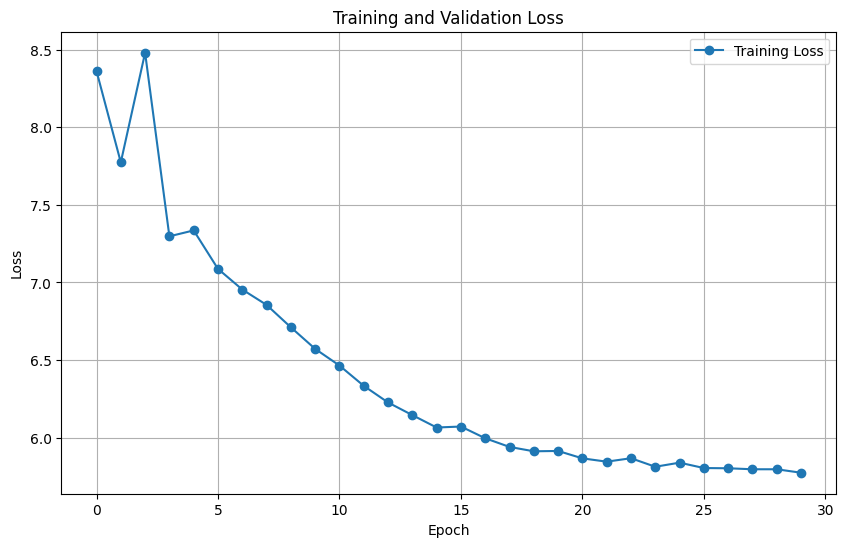

In [55]:
# Read the CSV log and plot training and validation losses
metrics_path = Path(logger.log_dir) / "metrics.csv"
metrics = pd.read_csv(metrics_path)

# Plot the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(metrics["epoch"], metrics["train_loss"], label="Training Loss", marker="o")
if "val_loss" in metrics.columns:
    plt.plot(metrics["epoch"], metrics["val_loss"], label="Validation Loss", marker="o")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

In [56]:
# Save the predictor
model_save_path = Path(f"./models/1")
if not model_save_path.exists():
    os.makedirs(model_save_path)

predictorTST.serialize(model_save_path)

# Make forecasts
forecasts = list(predictorTST.predict(test_ds))

In [57]:
from data.get_data import load_model_and_get_prediction
import datetime

In [71]:
date = datetime.datetime.now().replace(hour=0, minute=0, second=0) + datetime.timedelta(days=70)
predicted_data = pd.DataFrame(load_model_and_get_prediction(int(date.timestamp()), 1))
predicted_data.head()

,timestamp,predicted_user_count
0,2025-02-02 00:00:00+01:00,428.457214
1,2025-02-02 00:15:00+01:00,417.905731
2,2025-02-02 00:30:00+01:00,403.134216
3,2025-02-02 00:45:00+01:00,386.668457
4,2025-02-02 01:00:00+01:00,357.106293


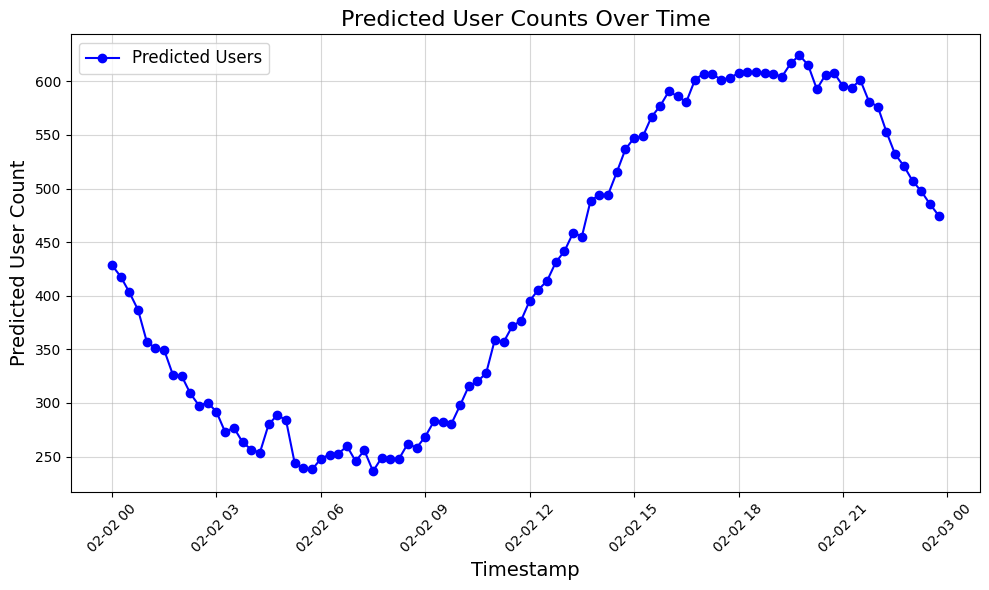

In [72]:
plt.figure(figsize=(10, 6))
plt.plot(predicted_data['timestamp'], predicted_data['predicted_user_count'], marker='o', linestyle='-', color='blue', label='Predicted Users')

plt.title('Predicted User Counts Over Time', fontsize=16)
plt.xlabel('Timestamp', fontsize=14)
plt.ylabel('Predicted User Count', fontsize=14)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.tight_layout()

plt.show()